In [156]:
import torch
from models.resnet import Resnet1D
N_CH = 10

In [157]:
x = torch.randn(1, 20, 100) # (batch_size, length, channels)
resnet = Resnet1D(n_in = 20, n_depth=3, dilation_growth_rate=1)

out = resnet(x)
print(out.shape) # (1, 20, 5)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"using  device: {device}")

torch.Size([1, 20, 100])
using  device: cuda


In [158]:
# count number of parameters
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"Number of parameters: {count_parameters(resnet)}")

Number of parameters: 4920


In [159]:
from models.encdec import Encoder

encoder = Encoder(input_emb_width=20)
encoder(x).shape

torch.Size([1, 512, 12])

In [160]:
from models.vqvae import VQVAE_251
args = {
    "quantizer": "ema"
}
vqvae = VQVAE_251(
    args
)

In [161]:
x = torch.randn(1, 128, 20) # (batch_size, length, channels)
vqvae(x)[0].shape


torch.Size([1, 128, 20])

In [162]:
vqvae.encode(x).shape

torch.Size([1, 16])

In [163]:
import numpy as np

def generate_sine_wave_data(batch_size, time_steps, channels, split_ratio=0.8, noise_std=0.05, seed=42):
    torch.manual_seed(seed)
    np.random.seed(seed)

    # 周波数・位相をランダムにする（チャンネルごと）
    freqs = np.random.uniform(1.5, 2.0, size=(batch_size, channels))
    phases = np.random.uniform(0, 2*np.pi, size=(batch_size, channels))

    # 時間軸
    t = np.linspace(0, 2 * np.pi, time_steps)

    # データ生成
    data = []
    for b in range(batch_size):
        sample = []
        for c in range(channels):
            y = np.sin(freqs[b, c] * t + phases[b, c])
            y += np.random.normal(0, noise_std, size=y.shape)
            sample.append(y)
        sample = np.stack(sample, axis=-1)  # [Time, Channel]
        data.append(sample)

    data = np.stack(data, axis=0)  # [Batch, Time, Channel]
    data_tensor = torch.tensor(data, dtype=torch.float32)

    # Split into train / val
    split_idx = int(batch_size * split_ratio)
    train_data = data_tensor[:split_idx]
    val_data = data_tensor[split_idx:]

    return train_data, val_data

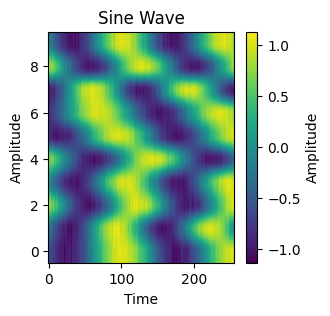

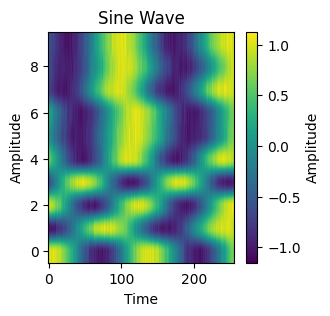

In [164]:
train, val = generate_sine_wave_data(10000, 256, N_CH, split_ratio=0.8, noise_std=0.05, seed=42)

# imshow
import matplotlib.pyplot as plt
import numpy as np
def plot_sine_wave(data, title="Sine Wave", xlabel="Time", ylabel="Amplitude"):
    # imshow
    plt.figure(figsize=(3, 3))
    plt.imshow(data, aspect='auto', cmap='viridis', origin='lower')
    plt.colorbar(label='Amplitude')
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)

    plt.show()

plot_sine_wave(train[0].numpy().T, title="Sine Wave", xlabel="Time", ylabel="Amplitude")
plot_sine_wave(val[0].numpy().T, title="Sine Wave", xlabel="Time", ylabel="Amplitude")


In [175]:
args = {
    "quantizer": "ema"
}
model = VQVAE_251(
    args,
    nb_code=128,
    n_channels=N_CH
)
lossi = []

# train model
from torch.utils.data import DataLoader, TensorDataset

train_dataset = TensorDataset(train)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-5)
num_epochs = 10

model = model.to(device)  # Move the model to the device

In [176]:


for epoch in range(num_epochs):
    for batch in train_loader:
        x = batch[0].to(device)  # Move the input batch to the device
        optimizer.zero_grad()
        x_out, q_loss, perplexity = model(x)

        loss_recon = torch.mean((x - x_out) ** 2)
        loss = loss_recon + q_loss * 0.25
        loss.backward()
        optimizer.step()
        lossi.append(loss.item())
        if (epoch + 1) % 1 == 0:
            print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}, Recon Loss: {loss_recon.item():.4f}, Quantization Loss: {q_loss.item():.4f}, Perplexity: {perplexity.item():.4f}")

Epoch [1/10], Loss: 0.5014, Recon Loss: 0.5012, Quantization Loss: 0.0007, Perplexity: 84.1201
Epoch [1/10], Loss: 0.5024, Recon Loss: 0.5022, Quantization Loss: 0.0008, Perplexity: 67.1523
Epoch [1/10], Loss: 0.5036, Recon Loss: 0.5035, Quantization Loss: 0.0007, Perplexity: 46.0025
Epoch [1/10], Loss: 0.5042, Recon Loss: 0.5040, Quantization Loss: 0.0007, Perplexity: 37.9256
Epoch [1/10], Loss: 0.5039, Recon Loss: 0.5037, Quantization Loss: 0.0007, Perplexity: 41.6180
Epoch [1/10], Loss: 0.5007, Recon Loss: 0.5005, Quantization Loss: 0.0007, Perplexity: 30.4445
Epoch [1/10], Loss: 0.5033, Recon Loss: 0.5031, Quantization Loss: 0.0007, Perplexity: 40.3078
Epoch [1/10], Loss: 0.5030, Recon Loss: 0.5029, Quantization Loss: 0.0007, Perplexity: 37.3453
Epoch [1/10], Loss: 0.5021, Recon Loss: 0.5019, Quantization Loss: 0.0007, Perplexity: 34.9082
Epoch [1/10], Loss: 0.5023, Recon Loss: 0.5021, Quantization Loss: 0.0007, Perplexity: 33.3349
Epoch [1/10], Loss: 0.5021, Recon Loss: 0.5019, Qu

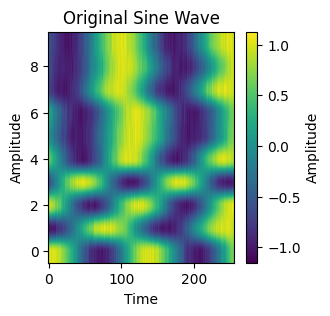

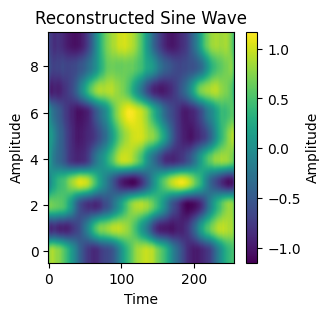

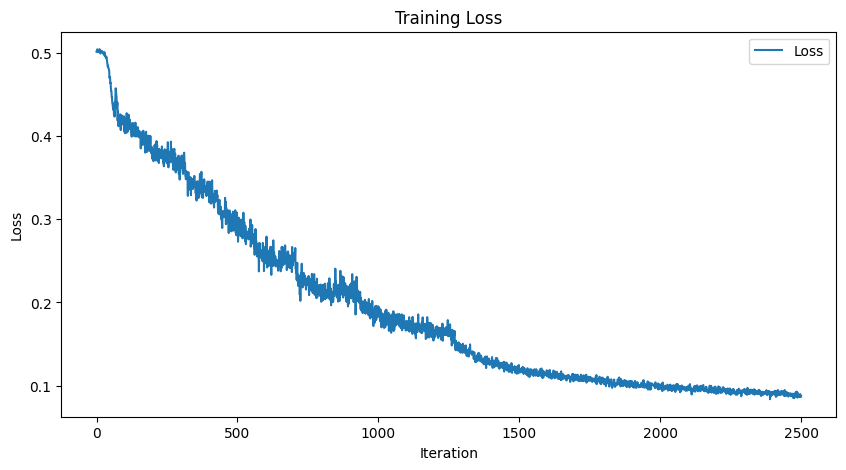

In [177]:

model.eval()
with torch.no_grad():
    recon = model(val[0:1].to(device))[0]
    plot_sine_wave(val[0].cpu().numpy().T, title="Original Sine Wave", xlabel="Time", ylabel="Amplitude")
    plot_sine_wave(recon[0].cpu().numpy().T, title="Reconstructed Sine Wave", xlabel="Time", ylabel="Amplitude")

# plot loss
plt.figure(figsize=(10, 5))
plt.plot(lossi, label='Loss')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.legend()
plt.show()